## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 3)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

> Implementation is from [base_example_to_try_different_implementations/improved_from_PredictiveIntelligenceLab_physics-informed.ipynb](../../../base_example_to_try_different_implementations/improved_from_PredictiveIntelligenceLab_physics-informed.ipynb) which is based on [Physics-informed-DeepONets](https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets/tree/main) repository. This method uses `jax`.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement3/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os
import time

import numpy as np

import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import trange

import scipy.io as io

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement3/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Data related methods

In [3]:
class Datahandler(Dataset):
    def __init__(self, X_train_, X_trunk_, Y_train_):

        # X_train = self.convert_np_to_tensor(X_train_)
        # X_trunk = self.convert_np_to_tensor(X_trunk_)
        # Y_train = self.convert_np_to_tensor(Y_train_)

        self.X_train = X_train_
        self.X_trunk = X_trunk_
        self.Y_train = Y_train_

    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array
    
    def __len__(self):
        return len(self.Y_train)  # Assuming X_train and X_trunk have the same length as y

    def __getitem__(self, index):
        return self.X_train[index,:], self.X_trunk, self.Y_train[index,:]

In [4]:
class DataProcessor:
    def __init__(self, batch_size, num_train = 1900, num_test = 100, \
                 num_inp_fn_points = 2601, num_out_fn_points = 2601):
        self.batch_size = batch_size
        self.num_train = num_train
        self.num_test = num_test
        self.num_inp_fn_points = num_inp_fn_points
        self.num_out_fn_points = num_out_fn_points
        self.num_Y_components = 2 # displacement field in 2D

        self.data, self.X_trunk, self.X_train, self.Y_train, \
            self.X_test, self.Y_test, self.X_train_mean, \
            self.X_train_std, self.Y_train_mean, self.Y_train_std, \
            self.tol = self.load_data()

        self.X_trunk_min = np.min(self.X_trunk, axis = 0)
        self.X_trunk_max = np.max(self.X_trunk, axis = 0)
    
    def load_data(self, tol = 1.0e-9):
        
        data = np.load(data_folder + 'LinearElasticity_samples.npz')

        # trunk input data ('xi' coordinates)
        X_trunk = data['u_mesh_nodes']
        
        # branch input data ('m' functions)
        X_train = data['m_samples'][:self.num_train,:]
        X_test = data['m_samples'][self.num_train:(self.num_train + self.num_test),:]

        X_train_mean = np.mean(X_train, 0)
        X_train_std = np.std(X_train, 0)

        X_train = (X_train - X_train_mean)/(X_train_std + tol)
        X_test = (X_test - X_train_mean)/(X_train_std + tol)

        # output data ('u' functions)
        Y_train = data['u_samples'][:self.num_train,:]
        Y_test = data['u_samples'][self.num_train:(self.num_train + self.num_test),:]

        if self.num_out_fn_points != Y_train.shape[1]:
            raise ValueError('num_out_fn_points does not match the number of output function points in the data')
        
        Y_train_mean = np.mean(Y_train, 0)
        Y_train_std = np.std(Y_train, 0)

        Y_train = (Y_train - Y_train_mean)/(Y_train_std + tol)
        Y_test = (Y_test - Y_train_mean)/(Y_train_std + tol)
        
        return data, X_trunk, X_train, Y_train, X_test, Y_test, X_train_mean, X_train_std, Y_train_mean, Y_train_std, tol
        
    def encoder_Y(self, x):
        x = (x - self.Y_train_mean)/(self.Y_train_std + self.tol)
        return x
    
    def encoder_Y_1d(self, x):    
        return self.encoder_Y(x)

    def decoder_Y(self, x):
        x = x*(self.Y_train_std + self.tol) + self.Y_train_mean
        return x
    
    def decoder_Y_1d(self, x):
        return self.decoder_Y(x)
    
    def encoder_X(self, x):
        x = (x - self.X_train_mean)/(self.X_train_std + self.tol)
        return x
    
    def encoder_X_1d(self, x):    
        return self.encoder_X(x)
    
    def decoder_X(self, x):
        x = x*(self.X_train_std + self.tol) + self.X_train_mean
        return x
    
    def decoder_X_1d(self, x):
        return self.decoder_X(x)

## Define network methods

In [5]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = jnp.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = jnp.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs
  return init, apply

In [15]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers, num_Y_components, lr = 0.001):

        self.num_inp_fn_points = branch_layers[0]
        self.num_br_outputs = branch_layers[-1]
        self.num_tr_outputs = trunk_layers[-1]
        self.out_coordinate_dimension = trunk_layers[0]
        self.num_Y_components = num_Y_components

        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=relu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=relu)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(lr, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()
        # Logger
        self.train_loss_log = []
        self.test_loss_log = []

    # Define opeartor net
    def operator_net(self, params, X_train, X_trunk):
        branch_params, trunk_params = params

        B = self.branch_apply(branch_params, X_train)
        T = self.trunk_apply(trunk_params, X_trunk)

        output_1 = jnp.dot(B[:,:self.num_tr_outputs], T.T)
        output_2 = jnp.dot(B[:,self.num_tr_outputs:], T.T)

        outputs = jnp.stack([output_1, output_2], axis = -1)

        return outputs
    
    # Define operator loss
    def loss_operator(self, params, batch):
        X_train = batch['X_train']
        X_trunk = batch['X_trunk']
        Y_train = batch['Y_train']
        
        # Compute forward pass
        Y_train_pred = self.operator_net(params, X_train, X_trunk)
        
        # Compute y_out
        loss = jnp.mean((Y_train.flatten() - Y_train_pred.flatten())**2)
        return loss
    
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_operator)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, train_data, test_data, batch_size=32, epochs = 1000, \
              lr=0.001, log=True, \
              loss_print_freq = 100):

        self.epochs = epochs
        self.batch_size = batch_size

        dataset = Datahandler(train_data['X_train'], \
                              train_data['X_trunk'], train_data['Y_train'])
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

        X_trunk = dataset.X_trunk

        self.train_loss_log = np.zeros((epochs, 1))
        self.test_loss_log = np.zeros((epochs, 1))

        # update lr in optimizer TODO
        
        # Main training loop
        for epoch in range(epochs):

            train_losses = []
            test_losses = []

            start_time = time.perf_counter()

            for X_train, _, Y_train in dataloader:
                
                X_train = X_train.numpy()
                Y_train = Y_train.numpy()

                # print(X_train.shape, X_trunk.shape, Y_train.shape)

                batch = {'X_train': X_train, 'X_trunk': X_trunk, 'Y_train': Y_train}

                self.opt_state = self.step(next(self.itercount), \
                                           self.opt_state, batch)
                
                # train loss
                params = self.get_params(self.opt_state)
                train_losses.append(self.loss_operator(params, batch))

                # test loss
                test_losses.append(self.loss_operator(params, test_data))

            end_time = time.perf_counter()
            epoch_time = end_time - start_time

            self.train_loss_log[epoch, 0] = np.mean(train_losses)
            self.test_loss_log[epoch, 0] = np.mean(test_losses)

            if log == True and (epoch % loss_print_freq == 0 or epoch == epochs - 1):
                print('='*30)
                print('Epoch: {:5d}, Train Loss (l2 squared): {:.3e}, Test Loss (l2 squared): {:.3e}, Time (sec): {:.3f}'.format(epoch, \
                                                  np.mean(train_losses), \
                                                  np.mean(test_losses), \
                                                  epoch_time))
                print('='*30)
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, X_train, X_trunk):
        s_pred = self.operator_net(params, X_train, X_trunk)
        return s_pred
    
    def predict(self, test_data):
        X_train = test_data['X_train']
        X_trunk = test_data['X_trunk']
        Y_train = test_data['Y_train']

        params = self.get_params(self.opt_state)
        y_pred = self.operator_net(params, X_train, X_trunk)

        return y_pred

## Load data

In [16]:
num_train = 1900
num_test = 100

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_br_outputs = 200 # 100 for u1 and 100 for u2
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_Y_components = 2 # displacement field in 2D

#batch_size
batch_size = 100
epochs = 1000
lr = 1.0e-3

data = DataProcessor(batch_size, num_train = num_train, num_test = num_test, num_inp_fn_points = num_inp_fn_points, num_out_fn_points = num_out_fn_points)

train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (1900, 2601)
Y_train: (1900, 2601, 2)
X_test: (100, 2601)
Y_test: (100, 2601, 2)
X_trunk: (2601, 2)


## Create model and train the network

In [17]:
branch_layers = [num_inp_fn_points, 128, 128, num_br_outputs]
trunk_layers =  [2, 128, 128, num_tr_outputs]

model = DeepONet(branch_layers, trunk_layers, num_Y_components, lr = lr)

In [18]:
# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs, lr = lr)

Epoch:     0, Train Loss (l2 squared): 5.672e-01, Test Loss (l2 squared): 5.594e-01, Time (sec): 2.096
Epoch:   100, Train Loss (l2 squared): 1.790e-01, Test Loss (l2 squared): 1.792e-01, Time (sec): 1.041
Epoch:   200, Train Loss (l2 squared): 1.396e-01, Test Loss (l2 squared): 1.375e-01, Time (sec): 1.121
Epoch:   300, Train Loss (l2 squared): 1.249e-01, Test Loss (l2 squared): 1.236e-01, Time (sec): 0.999
Epoch:   400, Train Loss (l2 squared): 1.063e-01, Test Loss (l2 squared): 1.052e-01, Time (sec): 1.024
Epoch:   500, Train Loss (l2 squared): 1.023e-01, Test Loss (l2 squared): 1.011e-01, Time (sec): 1.084
Epoch:   600, Train Loss (l2 squared): 9.388e-02, Test Loss (l2 squared): 9.251e-02, Time (sec): 1.084
Epoch:   700, Train Loss (l2 squared): 9.523e-02, Test Loss (l2 squared): 9.446e-02, Time (sec): 1.046
Epoch:   800, Train Loss (l2 squared): 9.319e-02, Test Loss (l2 squared): 9.219e-02, Time (sec): 1.012
Epoch:   900, Train Loss (l2 squared): 7.556e-02, Test Loss (l2 squared):

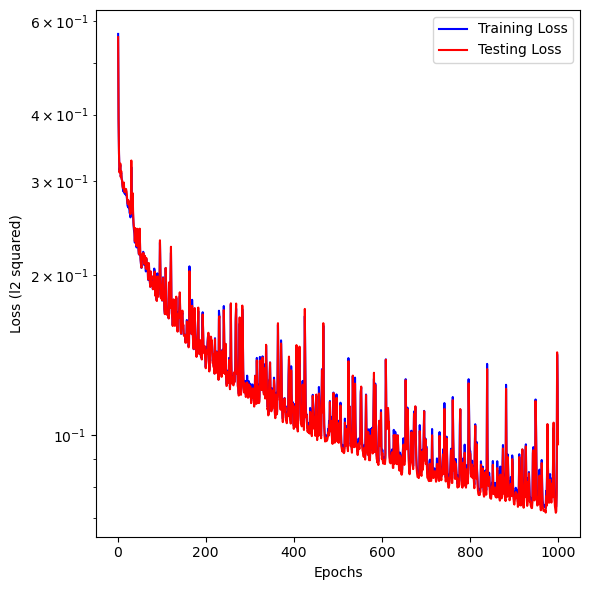

In [19]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [20]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data)
Y_test_pred = np.array(Y_test_pred)

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2601, 2), test_pred shape: (100, 2601, 2)
Num tests:   100, Mean Loss (rel l2): 3.062e-01, Std Loss (rel l2): 1.517e-01


In [21]:
def get_FE_space(mesh_file = data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector = False):
    mesh = dl.Mesh()
    with dl.XDMFFile(mesh_file) as infile:
        infile.read(mesh)
    if is_vector:
        V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)
    else:
        V = dl.FunctionSpace(mesh, "Lagrange", 1)
    return V

In [22]:
Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
i_pred = Y_test_pred[0, :, :].flatten()
u_fn = dl.Function(Vu)
u_vec = u_fn.vector().get_local()
print('u_vec shape: {}, i_pred shape: {}'.format(u_vec.shape, i_pred.shape))

u_vec shape: (5202,), i_pred shape: (5202,)


i_plot =    26, error (rel l2): 1.395e-02
i_plot =    86, error (rel l2): 1.078e-02
i_plot =     2, error (rel l2): 8.464e-03
i_plot =    55, error (rel l2): 7.815e-03
i_plot =    75, error (rel l2): 9.114e-03
i_plot =    93, error (rel l2): 1.446e-02
i_plot =    16, error (rel l2): 9.771e-03
i_plot =    73, error (rel l2): 8.960e-03
i_plot =    54, error (rel l2): 2.270e-02
i_plot =    95, error (rel l2): 6.476e-03
i_plot =    53, error (rel l2): 2.261e-02
i_plot =    92, error (rel l2): 3.973e-03
i_plot =    78, error (rel l2): 3.311e-03
i_plot =    13, error (rel l2): 7.800e-03
i_plot =     7, error (rel l2): 1.994e-02
i_plot =    30, error (rel l2): 3.897e-02


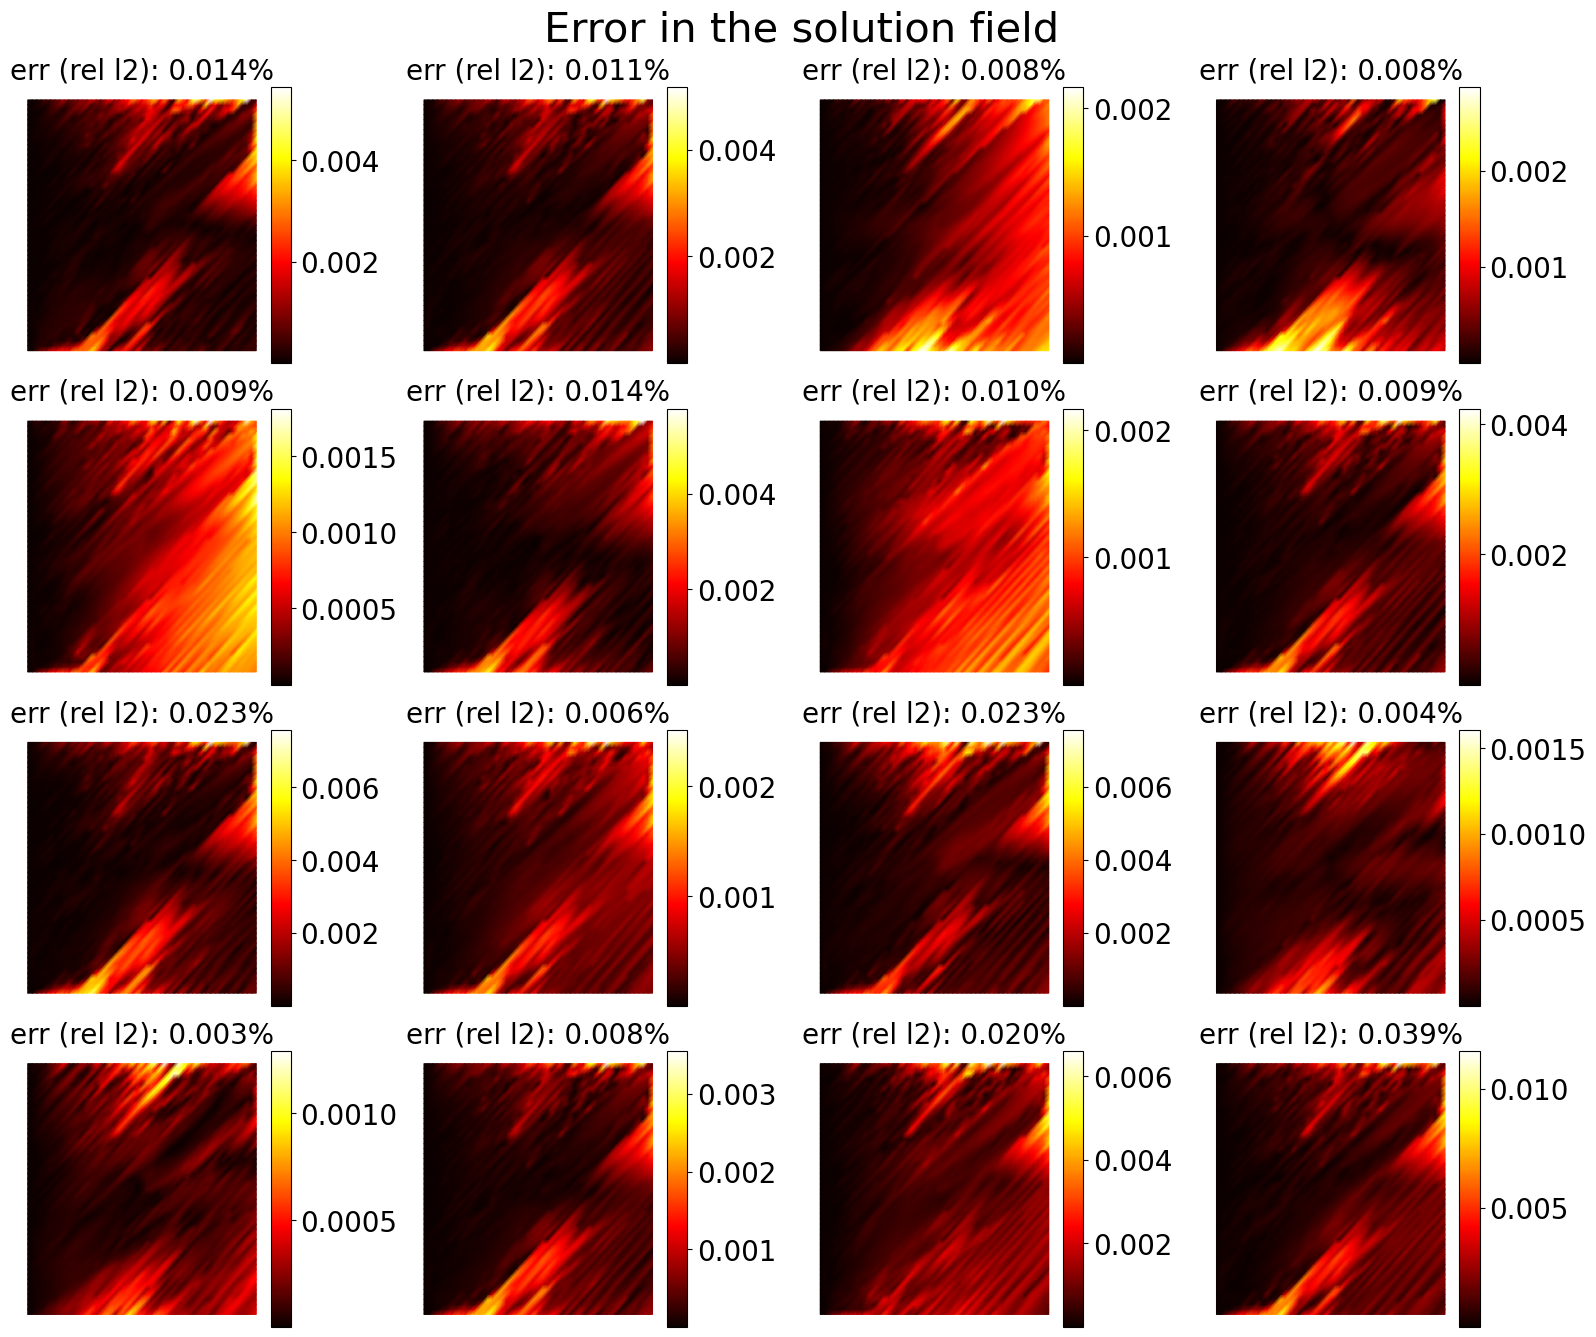

In [23]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + 'LinearElasticity_m_mesh.xdmf')

Y_spatial_points = data.X_trunk

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows*cols, replace=False)

for i in range(rows):
    for j in range(cols):
        i_plot = i_choices[i*cols + j]

        i_pred = Y_test_pred[i_plot, :, :]
        i_truth = Y_test[i_plot, :, :]
        if decode:
            i_pred = data.decoder_Y_1d(i_pred)
            i_truth = data.decoder_Y_1d(i_truth)

        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot_fenics(axs[i,j], i_diff.flatten(), \
                                     Vu, \
                                     cmap = 'hot', \
                                     add_displacement_to_nodes = False, \
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
        axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    18, error (rel l2): 9.469e-03
i_plot =    29, error (rel l2): 7.056e-03
i_plot =    64, error (rel l2): 5.396e-03
i_plot =    92, error (rel l2): 3.973e-03


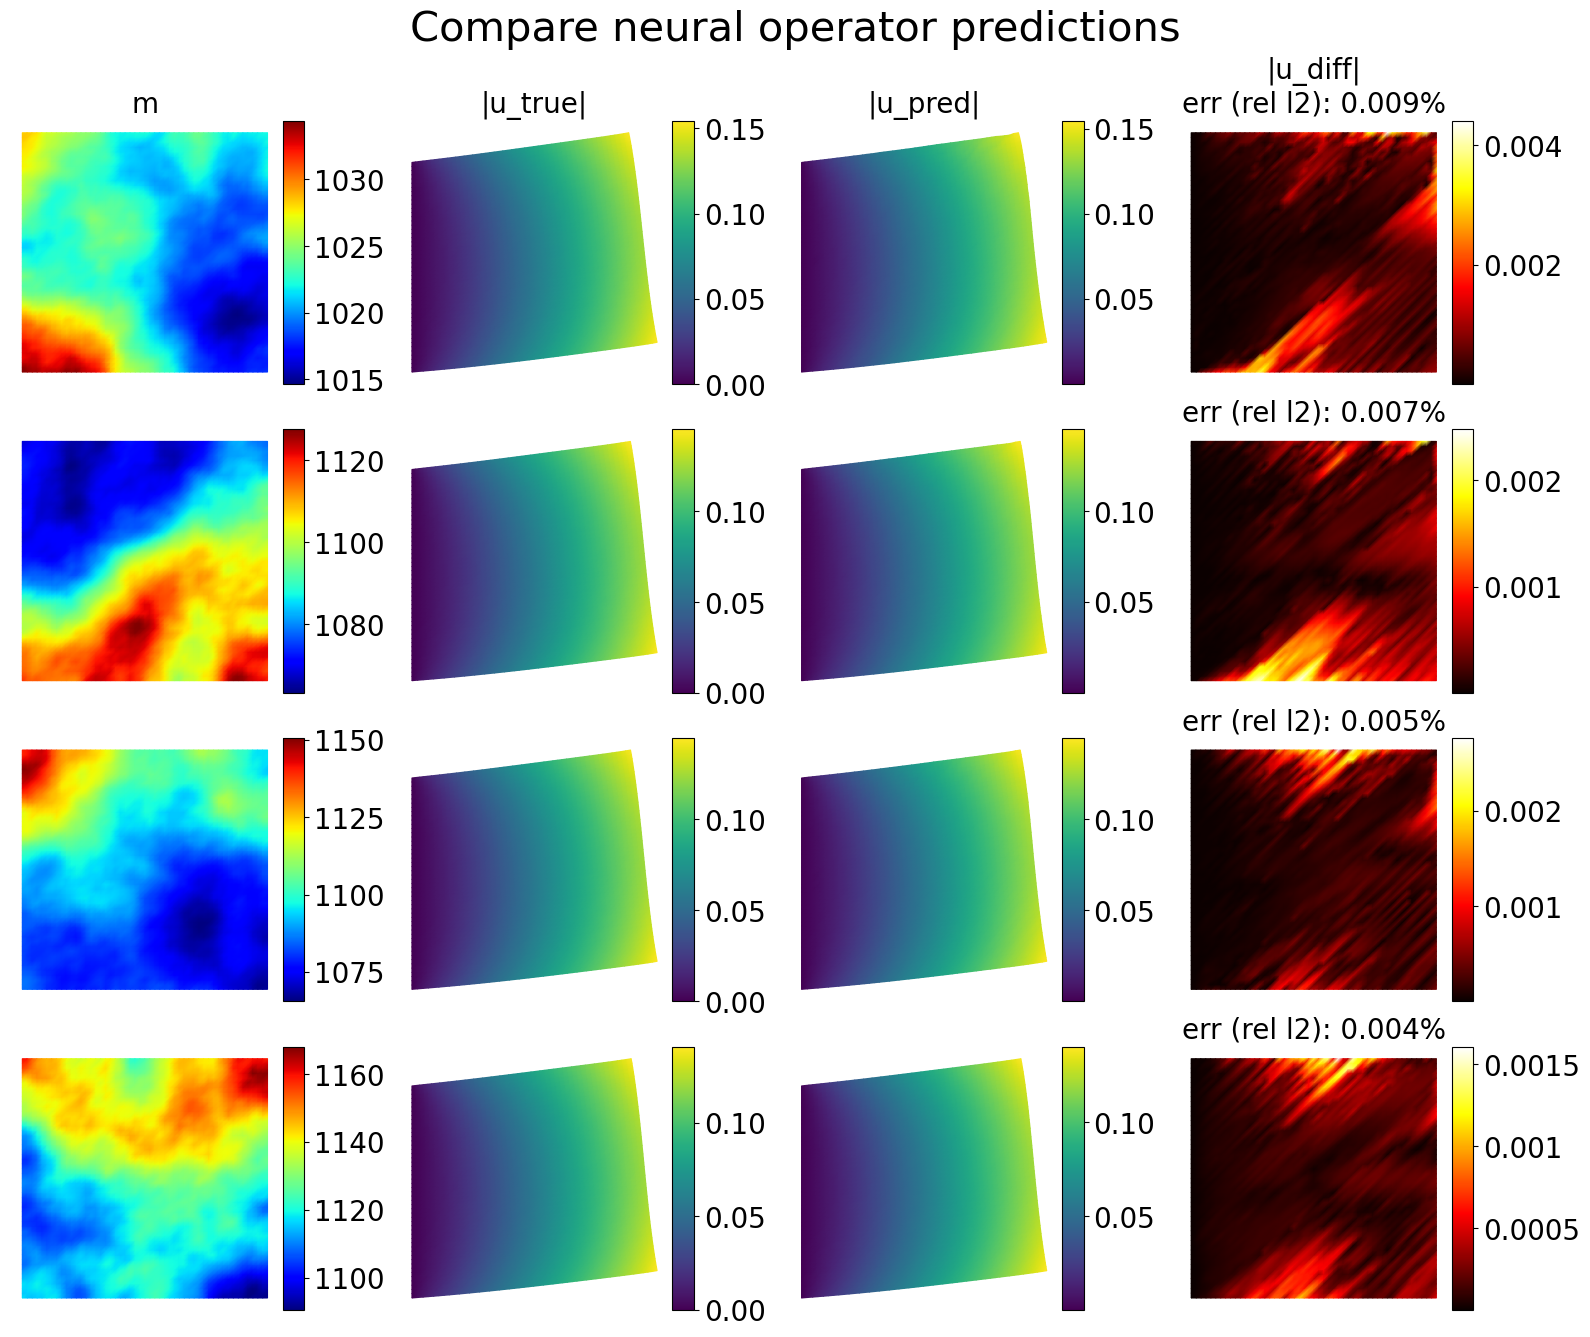

In [24]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + 'LinearElasticity_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', '|u_true|', '|u_pred|', '|u_diff|']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot, :, :]
    i_truth = Y_test[i_plot, :, :]
    i_m_test = data.X_test[i_plot, :]
    if decode:
        i_pred = data.decoder_Y_1d(i_pred)
        i_truth = data.decoder_Y_1d(i_truth)
        i_m_test = data.decoder_X_1d(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        if j == 0:
            cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps
            [j])
        elif j == cols - 1:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = False,\
                                     is_displacement = True)
        else:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = True,\
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()


# Scratch

In [14]:
# Define opeartor net
X_train, X_trunk, Y_train = train_data['X_train'], train_data['X_trunk'], train_data['Y_train']

branch_params, trunk_params = model.get_params(model.opt_state)

B = model.branch_apply(branch_params, X_train)
T = model.trunk_apply(trunk_params, X_trunk)

print('B: ', B.shape)
print('T: ', T.shape) 

output_1 = jnp.dot(B[:,:num_tr_outputs], T.T)
output_2 = jnp.dot(B[:,num_tr_outputs:], T.T)

Y_train_pred = jnp.stack([output_1, output_2], axis = -1)
print('Y_train_pred: ', Y_train_pred.shape)

# Y_train_pred = jnp.dot(B, T.T)

# # Compute y_out
loss = jnp.mean((Y_train.flatten() - Y_train_pred.flatten())**2)
print('loss: ', loss)

B:  (1900, 200)
T:  (2601, 100)
Y_train_pred:  (1900, 2601, 2)
loss:  1.3910347


Array([[ 0.11991608, -0.04565387,  0.14565414, ..., -0.08746988,
         0.01485354, -0.25917453],
       [ 0.22808053, -0.07680468,  0.27184284, ..., -0.20245996,
         0.00624898, -0.4913841 ],
       [ 0.2770588 , -0.10317316,  0.3294065 , ..., -0.18219072,
         0.04559663, -0.6264132 ],
       ...,
       [ 0.32507846, -0.11840803,  0.44578984, ..., -0.25856748,
         0.04363883, -0.7391114 ],
       [-0.5108018 , -0.7323757 ,  4.3643084 , ..., -0.99505025,
         2.6583505 , -1.3139488 ],
       [-0.04777085, -0.02863291,  1.7305307 , ..., -0.09151453,
         1.3005325 , -0.37526327]], dtype=float32)